# Experiment with UNet Training

## Validate Test Sample

Look at the sampled test patch using balanced sampling methods. Make sure that input and label match.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import xarray as xr
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from rattlinbog.estimators.nn_regression import NNEstimator
from rattlinbog.sampling.sample_patches_from_dataset import sample_patches_from_dataset
from rattlinbog.th_extensions.nn.unet import UNet
from rattlinbog.th_extensions.utils.data.streamed_xarray_dataset import StreamedXArrayDataset
from rattlinbog.th_extensions.utils.dataset_splitters import split_to_params_and_labels

In [2]:
TEST_PATCH = Path("/home/braml/code/github/use-case-wetland-water-stress/tests/resources/approved/test_stochastic_training.test_stochastic_patch_samples_from_dataset.approved.zarr")

In [3]:
test_patch = xr.open_zarr(TEST_PATCH)
test_patch

<xarray.Dataset>
Dimensions:      (y: 32, x: 32, parameter: 9)
Coordinates:
    band         int64 ...
  * parameter    (parameter) <U14 'SIG0-HPAR-C1' ... 'SIG0-HPAR-STD'
  * x            (x) float64 5.316e+06 5.316e+06 ... 5.317e+06 5.317e+06
  * y            (y) float64 1.657e+06 1.657e+06 ... 1.656e+06 1.656e+06
Data variables:
    mask         (y, x) float32 dask.array<chunksize=(32, 32), meta=np.ndarray>
    params       (parameter, y, x) float32 dask.array<chunksize=(9, 32, 32), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    name:     sample_0

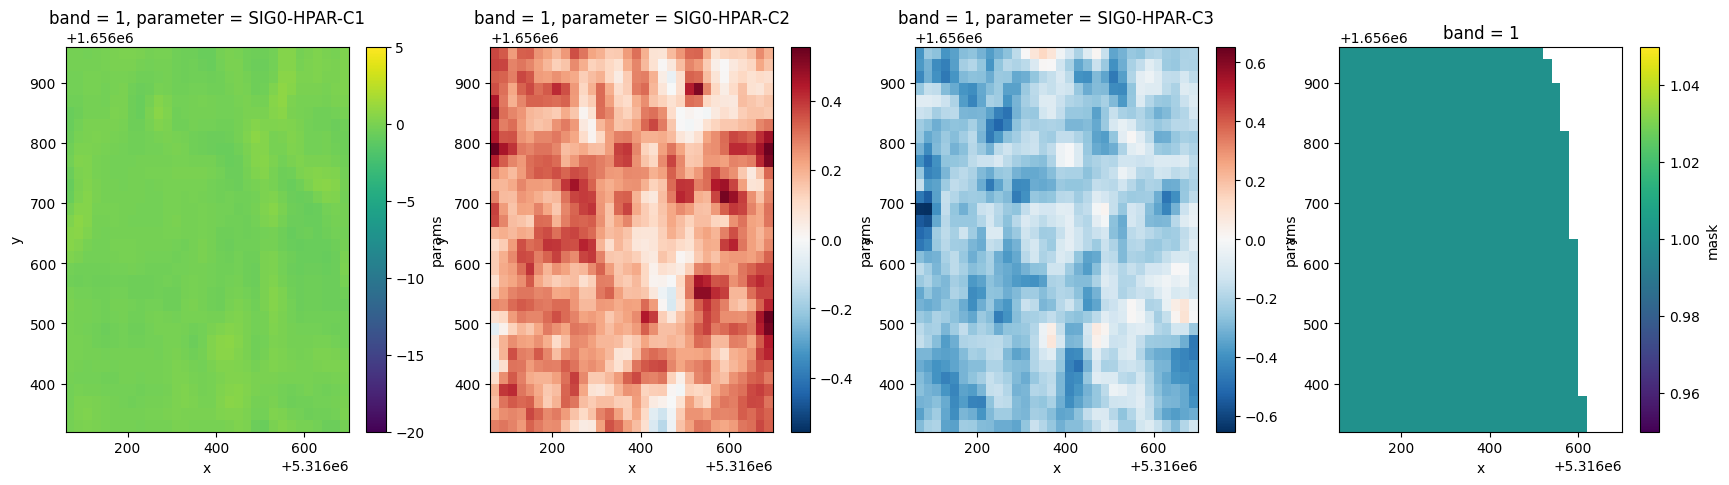

In [4]:
_, axes = plt.subplots(ncols=4, figsize=(21, 5))
test_patch['params'][0, ...].plot(ax=axes[0], vmin=-20, vmax=5)
test_patch['params'][1, ...].plot(ax=axes[1])
test_patch['params'][2, ...].plot(ax=axes[2])
test_patch['mask'].plot(ax=axes[3])
plt.draw()

## Test Data Loading

In [2]:
tile_ds = xr.open_zarr("/eodc/private/tuwgeo/users/braml/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E051N015T3/SIG0-HPAR-MASK____RAMSAR-AT-01_E051N015T3_EU020M__.zarr")

In [3]:
tile_ds['mask']

In [4]:
tile_ds['mask'].max().values.item()

1.0

In [5]:
array_stream = StreamedXArrayDataset(
    sample_patches_from_dataset(tile_ds, 64, 10000, never_nans=True, rnd_generator=np.random.default_rng(42)),
    split_to_params_and_labels, 10000)

patch_loader = DataLoader(array_stream, batch_size=8)

In [6]:
batch = next(iter(patch_loader))

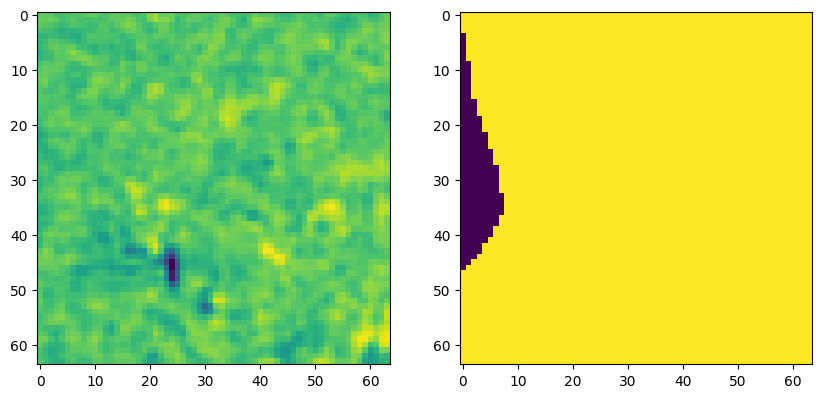

In [7]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
params, label = batch
axes[0].imshow(params[1, 7])
axes[1].imshow(label[1, 0])
plt.draw()

## Training simple U-Net

In [8]:
unet = UNet(9, [64, 128, 256], 1).to(device=th.device('cuda'))

In [9]:
estimator = NNEstimator(unet, 16, lambda p: Adam(p), loss_fn=BCEWithLogitsLoss())

In [10]:
estimator.fit(array_stream)

fitting: 100%|██████████| 625/625 [12:21<00:00,  1.19s/it]


NNEstimator(batch_size=16, loss_fn=BCEWithLogitsLoss(),
            net=UNet(
  (_encoding): Sequential(
    (0): EncoderBlock(
      (conv_block): Sequential(
        (cv1): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (...
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (cv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
    )
    (RemoveSkips): RemoveSkips()
  )
  (_prediction): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
),
            optim_factory=<function <lambda> at 0x7fb25bc127a0>)

In [11]:
estimate = estimator.predict(params[0].numpy())

In [13]:
estimate.min()

-0.69667035

In [14]:
print(f"{params[0].min()}, {params[0].max()}")

-17.75666618347168, 45.625


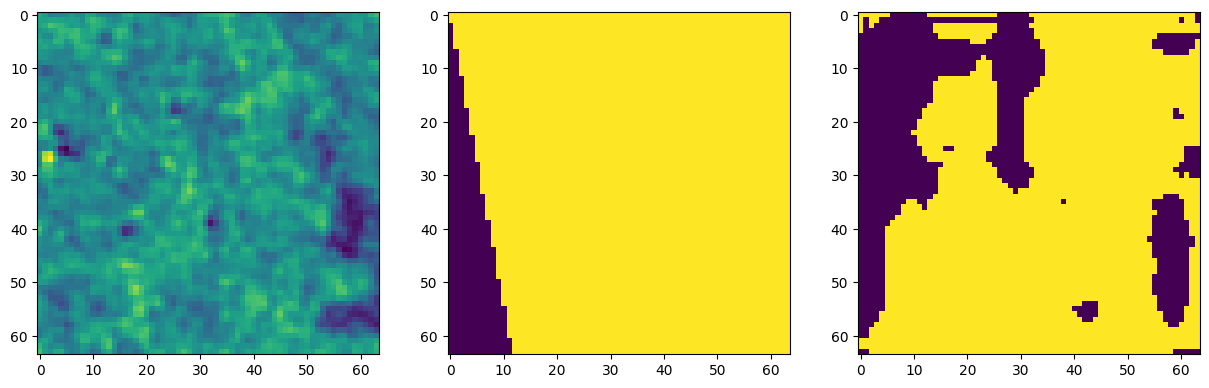

In [18]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
params, label = batch
axes[0].imshow(params[0, 7])
axes[1].imshow(label[0, 0])
axes[2].imshow(estimate[0] > 0.0)
plt.draw()